# Evaluación de modelos entrenados

In [1]:
import os
# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

2025-05-04 00:30:41.473077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746315041.497367   37440 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746315041.504422   37440 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Carga de datos

In [2]:
# Define the model architecture again (same as during training)
learning_rate = 0.005 #Should not matter for predictions

past_data_shape = [17, 7]  # (time_steps, num_features)
future_data_shape = [3, 4]  # (time_steps, num_features)
target_shape=3

past_data_layer = tf.keras.layers.Input(shape=past_data_shape, name="past_data")
#x = tf.keras.layers.SpatialDropout1D(0.05, name="spatial_dropout")(past_data_layer)
encoder_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False))(past_data_layer)
#encoder_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True, recurrent_dropout=0.1))(past_data_layer)
#encoder_lstm = tf.keras.layers.LSTM(100, return_sequences=False)(encoder_lstm)
# dropout
#encoder_lstm = tf.keras.layers.Dropout(0.2)(encoder_lstm)

# Decoder part (LSTM for future exogenous features)
future_data_layer = tf.keras.layers.Input(shape=future_data_shape, name="future_data")
#decoder_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))(future_data_layer)
decoder_lstm = tf.keras.layers.LSTM(4, return_sequences=False)(future_data_layer)

# Combine the outputs of encoder and decoder (you can concatenate or merge them)
merged = tf.keras.layers.concatenate([encoder_lstm, decoder_lstm])
#merged = tf.keras.layers.BatchNormalization()(merged)
#merged = tf.keras.layers.Reshape((1, -1))(merged)  # Reshape to (batch, timesteps=1, features) for LSTM
#merged = tf.keras.layers.LSTM(250)(merged) # DOES NOT MAKE SENSE AFTER MERGING

# dropout 
# merged = tf.keras.layers.Dropout(0.1)(merged)
# merged = tf.keras.layers.Dense(9, activation="relu")(merged)

# Final output layer
output_units = target_shape # Output shape should match the target sequence
# merged = tf.keras.layers.Dense(output_units * 2)(merged)
outputs = tf.keras.layers.Dense(output_units)(merged)
# Create the model
model = tf.keras.Model(inputs=[past_data_layer, future_data_layer], outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "hum1074.weights.h5"
model.load_weights(path_checkpoint)

# Optionally check the model summary to confirm weights have been loaded
model.summary()


I0000 00:00:1746315046.847433   37440 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1977 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ past_data           │ (None, 17, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_data         │ (None, 3, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512)       │    540,672 │ past_data[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 4)         │        144 │ future_data[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 516)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │      1,551 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 542,367 (2.07 MB)

 Trainable params: 542,367 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

/home/jr/miniconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ past_data           │ (None, 17, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_data         │ (None, 3, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512)       │    540,672 │ past_data[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 4)         │        144 │ future_data[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 516)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │      1,551 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 542,367 (2.07 MB)

 Trainable params: 542,367 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
DATA_PATH = "../3_data_windows/processed_windows/paquetes_s6_cov_p17.pkl"
BATCH_SIZE = 64

with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)
    
x_val = data["test"]["relative_humidity"]["past_variables"]
future_val = data["test"]["relative_humidity"]["future_variables"]
y_val = data["test"]["relative_humidity"]["y"]

dataset_val = tf.data.Dataset.from_tensor_slices(((x_val, future_val), y_val))
dataset_val = dataset_val.shuffle(buffer_size=15000)
dataset_val = dataset_val.batch(BATCH_SIZE)


In [4]:
predictions_all = []
y_true_all = []

for batch in dataset_val:
    (x_past, x_future), y = batch
    predictions = model.predict((x_past, x_future))

    # Convert to numpy arrays and flatten
    y_np           = y.numpy().reshape(-1)
    predictions_np = predictions.reshape(-1)
    
    # Accumulate into lists
    y_true_all.extend(y_np.tolist())
    predictions_all.extend(predictions_np.tolist())

# Convert lists back to numpy arrays
y_true_arr      = np.array(y_true_all)
predictions_arr = np.array(predictions_all)

# Calculate RMSE
mse = mean_squared_error(y_true_arr, predictions_arr)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


I0000 00:00:1746315073.004163   37498 cuda_dnn.cc:529] Loaded cuDNN version 90800


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
MSE: 0.1073

In [5]:
def denormalize(data, mean, std):
    """
    Denormalize the data using the mean and standard deviation.
    """
    return data * std + mean
  

In [8]:
MEAN = 69.07693818
STD = 17.73192058

def plot_predictions(x_past, y, predictions):
# Denormalize
    history    = denormalize(x_past[:, -1], MEAN, STD)    # last feature over history window
    actual     = denormalize(y, MEAN, STD)
    forecast   = denormalize(predictions, MEAN, STD)

    H = len(history)
    F = len(actual)

    # Build continuous "actual" curve: history + actual future
    full_actual = np.concatenate([history, actual])

    # Build forecast curve that starts at the last history point
    # so its first value sits on history[-1]
    full_forecast = np.concatenate([[history[-1]], forecast])

    # Time axes
    t_full = np.arange(H + F)                            # for full_actual
    t_forc = np.arange(H - 1, H - 1 + len(full_forecast))  # for full_forecast

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(t_full,      full_actual,    label='Actual (history + future)', linewidth=2)
    plt.plot(t_forc,      full_forecast,  label='Forecast',               linestyle='--', linewidth=2)
    plt.axvline(H - 1,    linestyle=':',  linewidth=1.5,             label='Forecast start')
    plt.grid(alpha=0.3)
    plt.title('Time Series: History → Actual vs. Forecast')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predictions shape: 64


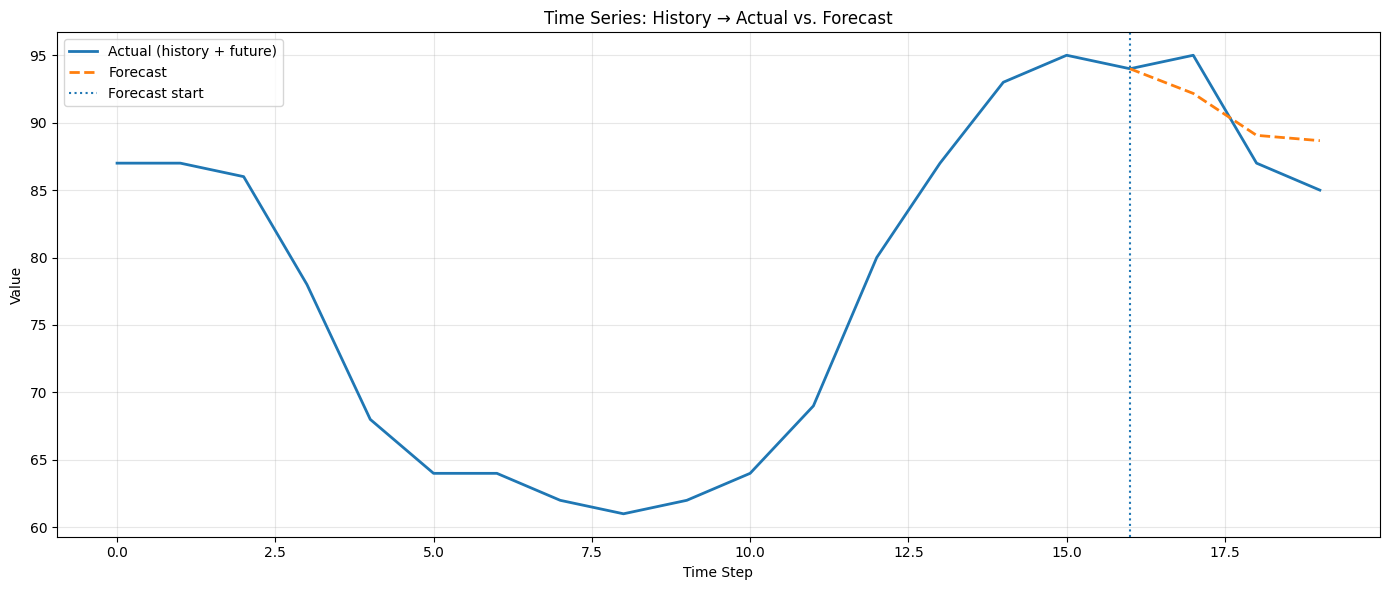

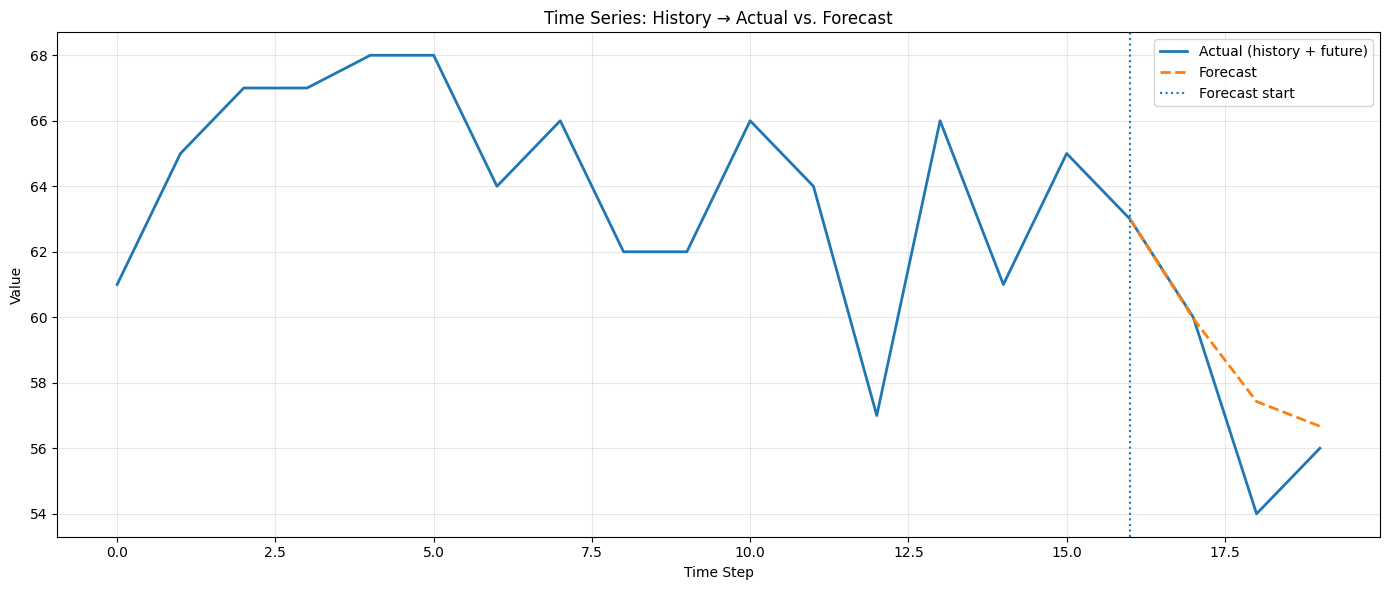

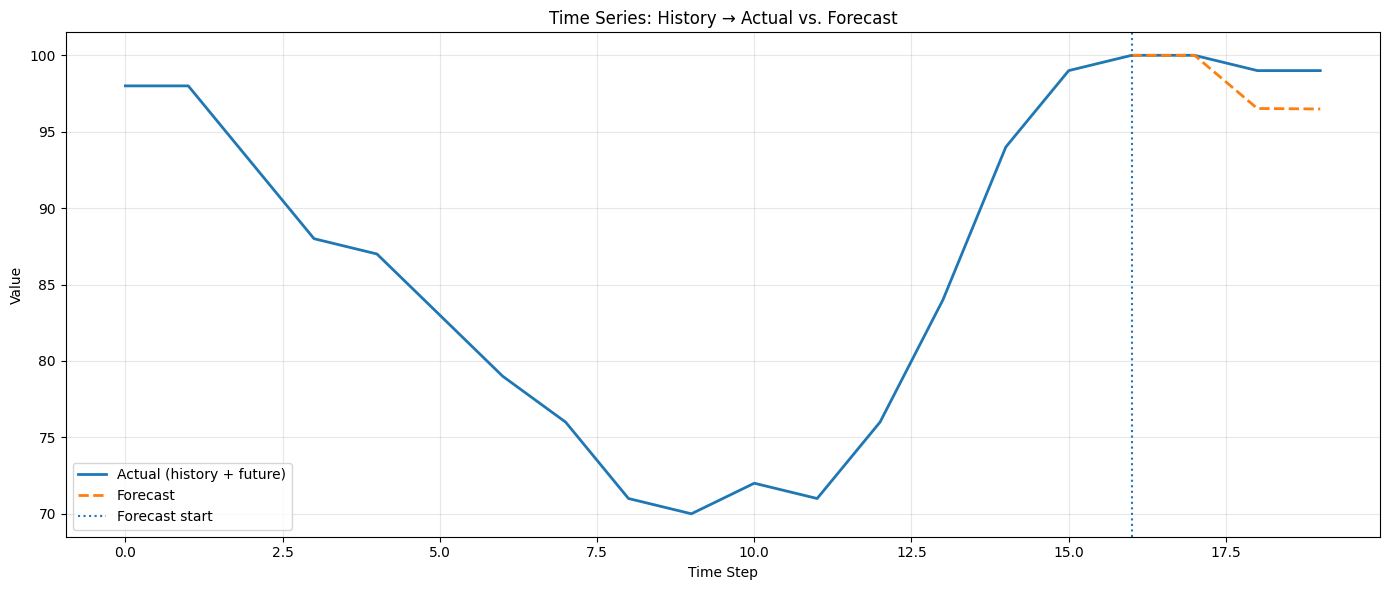

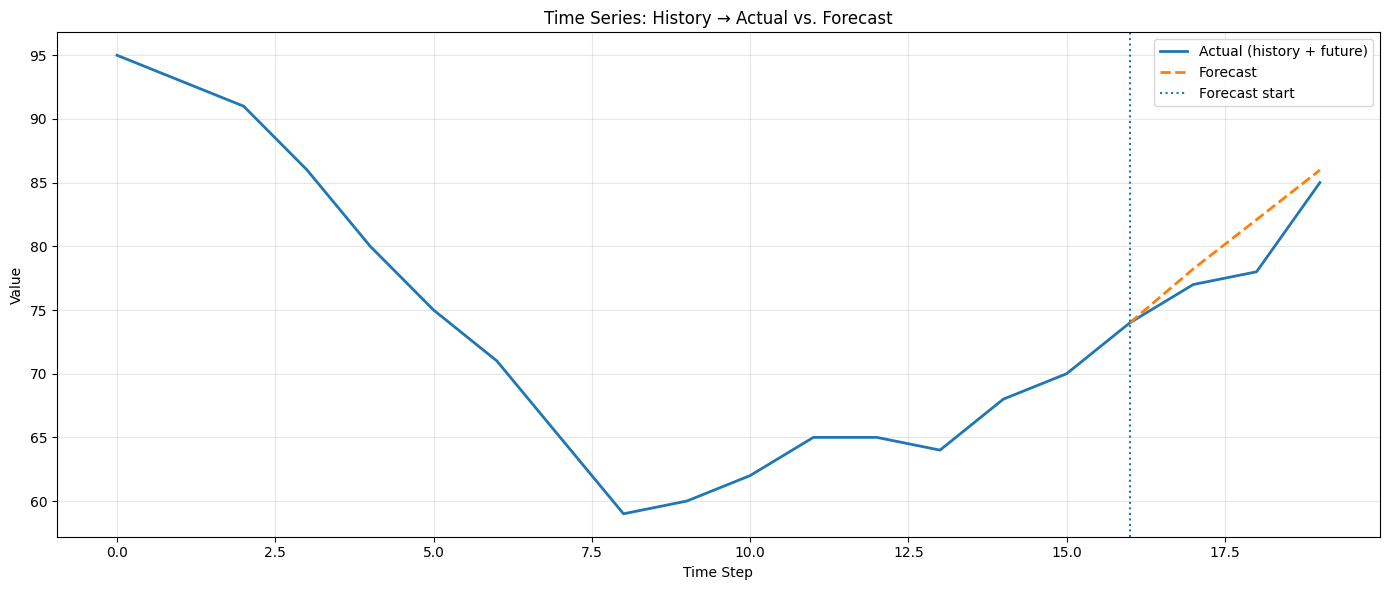

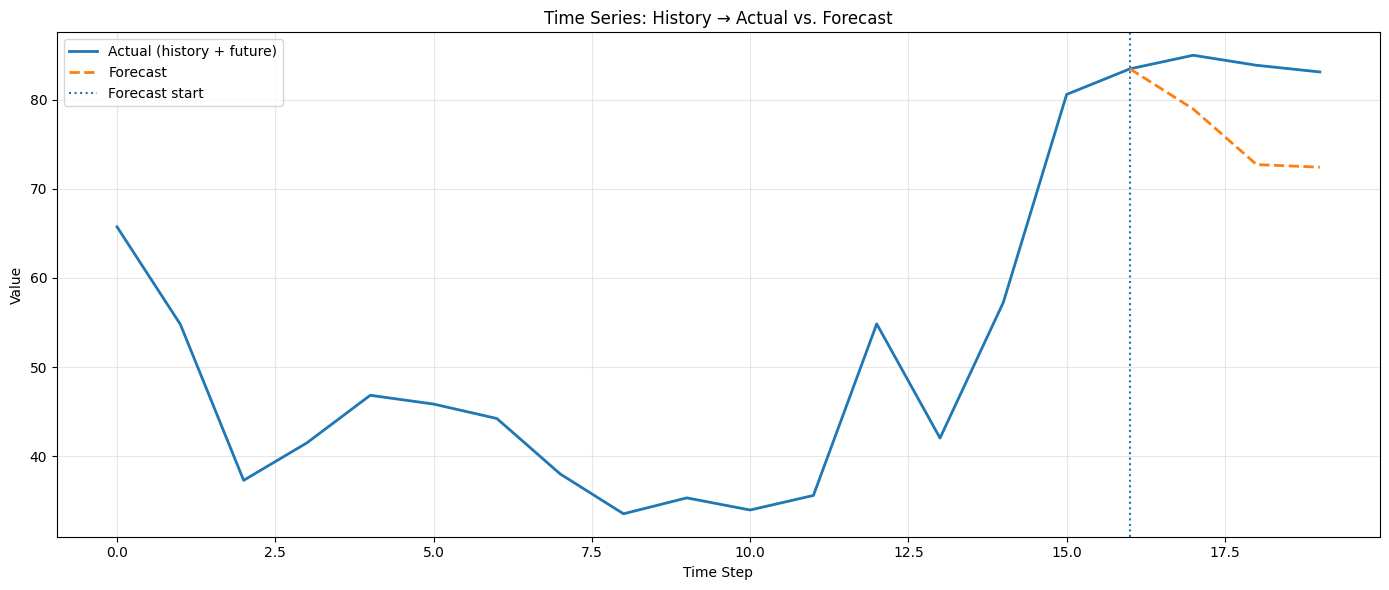

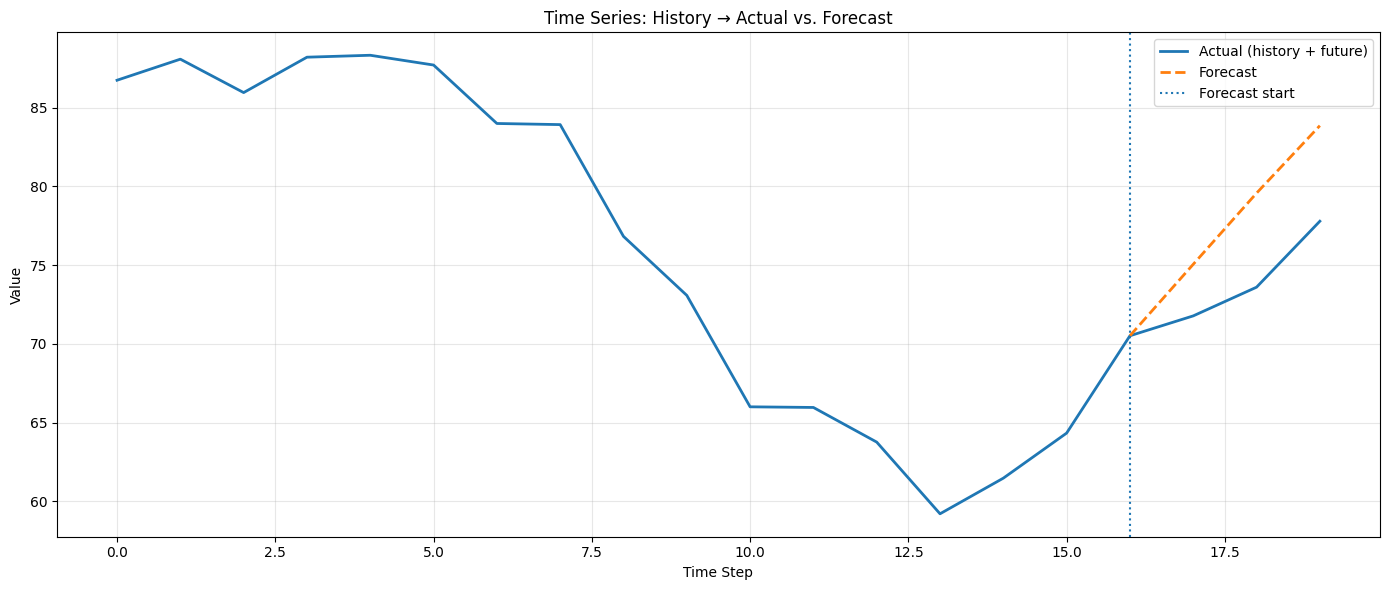

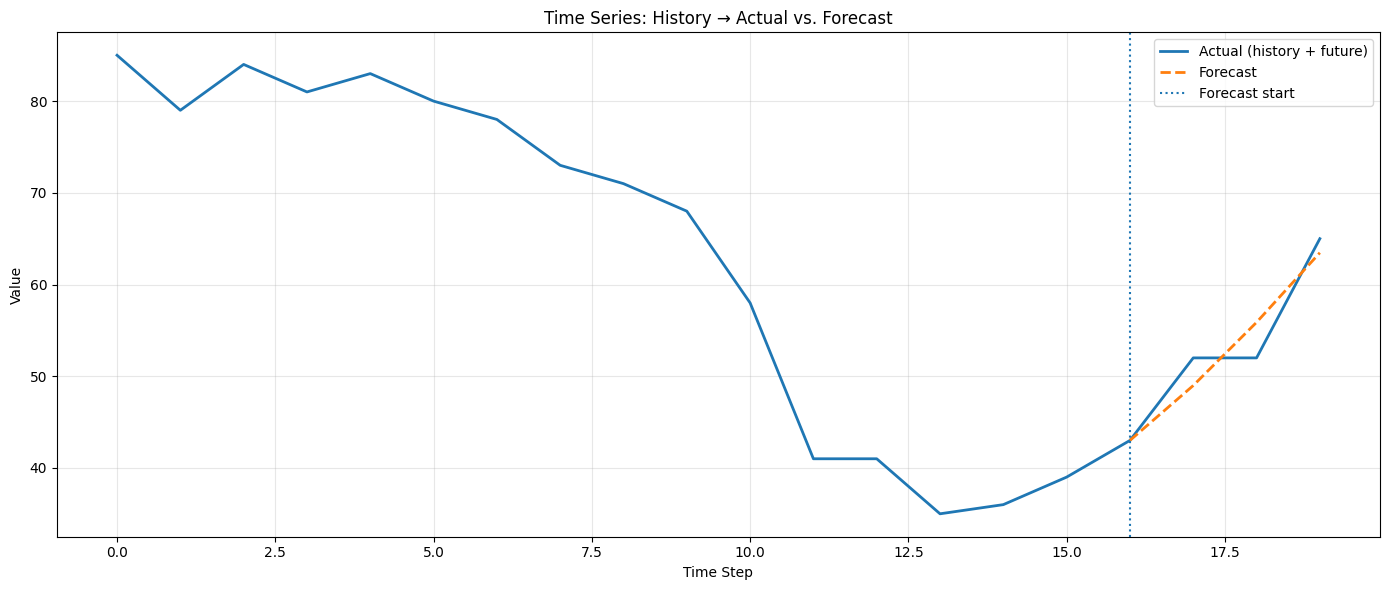

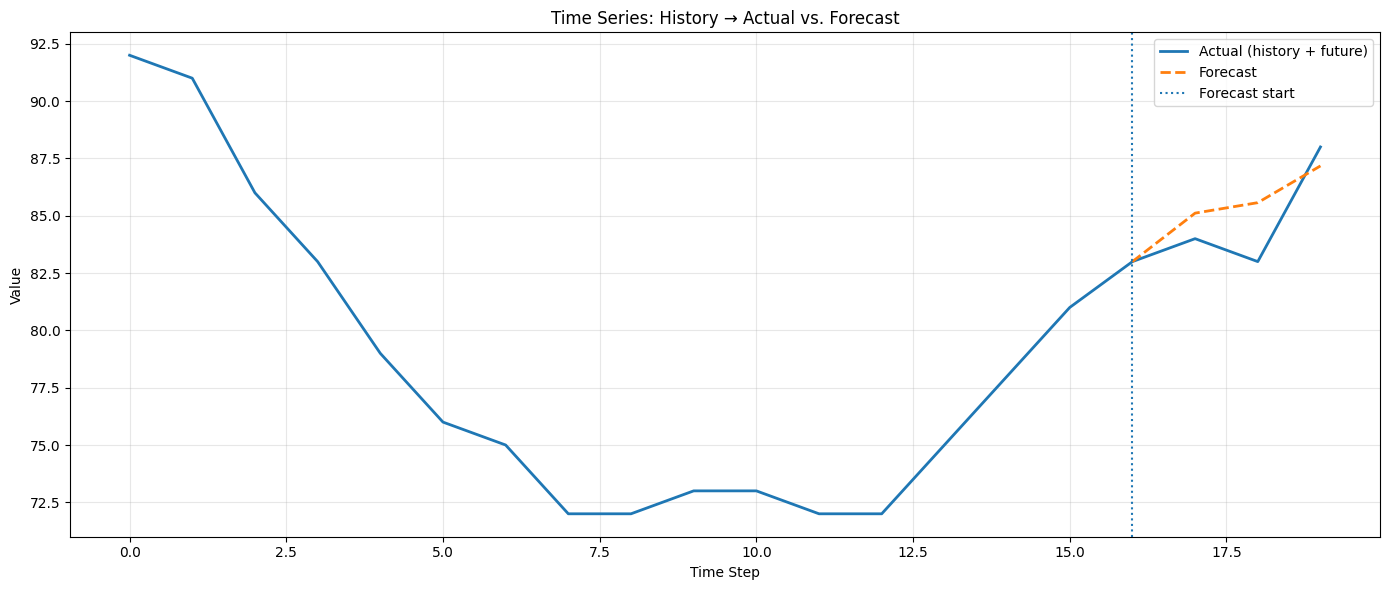

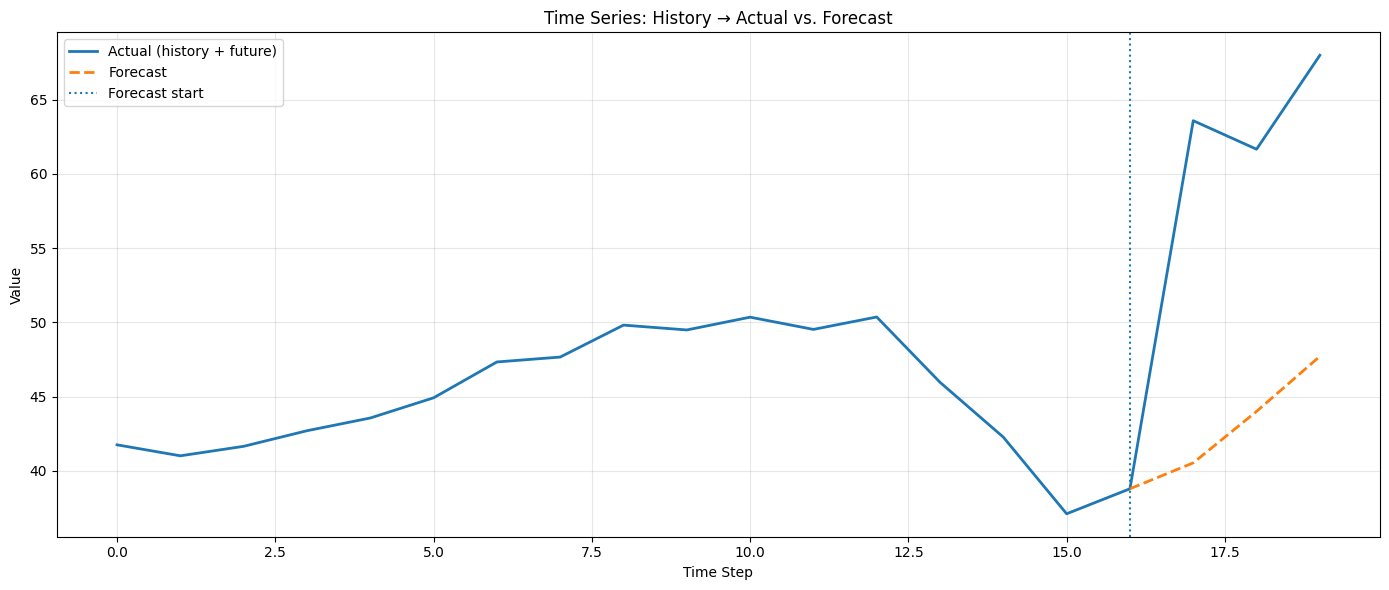

In [9]:

for batch in dataset_val.take(1):
    (x_past, x_future), y = batch
    predictions = model.predict((x_past, x_future))

    print("predictions shape:", predictions.shape[0])
    for i in range(0, 9):
        plot_predictions(x_past[i], y[i], predictions[i])
        plt.show()